# Initialise 

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [2]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/male_vs_female/', verbose=1)

import logging

# logging.basicConfig(filename='c14.log',
#                             filemode='a',
#                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                             level=logging.INFO)

In [3]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.livermodels

In [4]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190722.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')

## todo

In [5]:
edata_male = c14.exp_data(data)
edata_female = c14.exp_data(data)

In [6]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=2)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'])
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [7]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [10]:
models = [c14.livermodels.Akl40]
models

[c14.livermodels.Akl40]

In [11]:
init_limit = {'r': (-3, 0), 
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3)
             }

In [12]:
%%time
results_male = fit_models(edata_male, models, step_size=2.0, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 118 ms, sys: 2.01 ms, total: 120 ms
Wall time: 116 ms


In [13]:
%%time
results_female = fit_models(edata_female, models, step_size=2.0, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 121 ms, sys: 5.9 ms, total: 127 ms
Wall time: 124 ms


Akl40


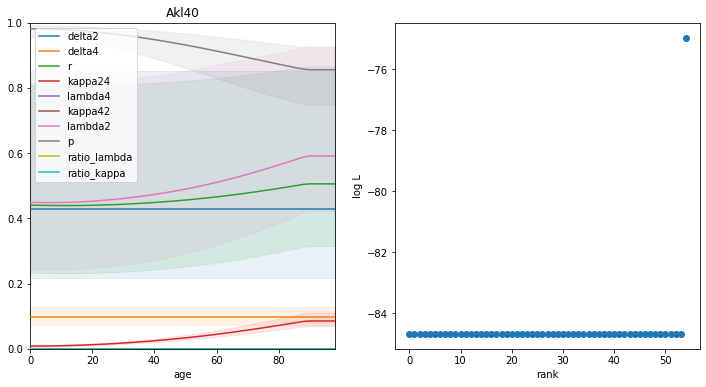

delta2    0.429452
delta4    0.096867
dtype: float64


In [15]:
for name, result in results_male.items():
    print(name)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    result['vis'].plot_parameter(result['point_estimate'], result['errors'], no_plot=[], axis=axs[0])
    axs[0].legend()
    axs[0].set_title(name)
    axs[0].set_ylim(0,1)
    
    fval = result['multistart_result']['fval']
    axs[1].scatter(np.arange(len(fval)), fval.values)
    axs[1].set_xlabel('rank')
    axs[1].set_ylabel('log L')
    
    plt.show()
   
    print(pd.Series(result['model'].tranform_parameters(result['point_estimate'])))

Akl40


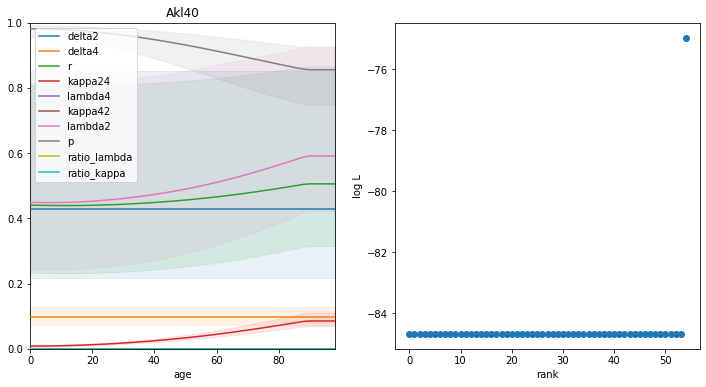

delta2    0.429452
delta4    0.096867
dtype: float64


In [16]:
for name, result in results_female.items():
    print(name)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    result['vis'].plot_parameter(result['point_estimate'], result['errors'], no_plot=[], axis=axs[0])
    axs[0].legend()
    axs[0].set_title(name)
    axs[0].set_ylim(0,1)
    
    fval = result['multistart_result']['fval']
    axs[1].scatter(np.arange(len(fval)), fval.values)
    axs[1].set_xlabel('rank')
    axs[1].set_ylabel('log L')
    
    plt.show()
   
    print(pd.Series(result['model'].tranform_parameters(result['point_estimate'])))